In [1]:
import pandas as pd
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore")

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


### Import Data

In [2]:
# Get historical crypto price data
cryptoPriceDf = pd.read_csv('data\TradingViewCryptoPrice.csv', index_col=0)
cryptoPriceDf.index = pd.to_datetime(cryptoPriceDf.index)

### Portfolio Construction

In [3]:
def getPortfolioTransactions(TransactionRecords, pairLimit):
    
    # initialize the varaible for extraction
    executedTrades = pd.DataFrame(columns=TransactionRecords.columns)
    mainOpenTransactionIDs = []
    pairOpenTransactionIDs = []

    for _, transaction in TransactionRecords.iterrows():

        # get current TransactionID
        TransactionID = str(transaction['Period No.']) + " " + str(transaction['Pair No.']) + " " + str(transaction['Round Trip No.'])

        # Close Transaction
        if transaction['Open/Close'] == "Close" and TransactionID in mainOpenTransactionIDs:
            executedTrades.loc[len(executedTrades)] = transaction
            mainOpenTransactionIDs.remove(TransactionID)
        # for the pair transaction record 
        elif transaction['Open/Close'] == "Close" and TransactionID in pairOpenTransactionIDs:
            executedTrades.loc[len(executedTrades)] = transaction
            pairOpenTransactionIDs.remove(TransactionID)

        # Open Transaction record
        if len(mainOpenTransactionIDs) < pairLimit and transaction['Open/Close'] == "Open" and TransactionID not in mainOpenTransactionIDs:
            executedTrades.loc[len(executedTrades)] = transaction
            mainOpenTransactionIDs.append(TransactionID)
        # for the pair transaction record
        elif transaction['Open/Close'] == "Open" and TransactionID in mainOpenTransactionIDs:
            executedTrades.loc[len(executedTrades)] = transaction
            pairOpenTransactionIDs.append(TransactionID)
    
    return executedTrades

In [4]:
# Scaling the transactions for each pair to fit the capitalPerPair
def transactionsScaling(executedTrades):

    # loop through each round trip of transaction
    for periodNo, pairNo, RoundTripNo in executedTrades.groupby(['Period No.','Pair No.', 'Round Trip No.']).count().index:
        # get the specific round trip
        roundTrip = executedTrades[(executedTrades['Period No.'] == periodNo) & (executedTrades['Pair No.'] == pairNo) & (executedTrades['Round Trip No.'] == RoundTripNo)]

        # calculate the multiplier for this round trip
        openTransaction = roundTrip[roundTrip['Open/Close'] == 'Open']
        multiplier = capitalPerPair / (openTransaction['Price'] * openTransaction['Quantity']).sum()

        # update the quantity with multiplier in order to fit the capitalPerPair
        executedTrades.loc[(executedTrades['Period No.'] == periodNo) & (executedTrades['Pair No.'] == pairNo) & (executedTrades['Round Trip No.'] == RoundTripNo), 'Quantity'] *= multiplier * 2 # *2 for 50% margin

    return executedTrades

### Calculate the return of the portfolio

In [5]:
def calculateCumPnLfPortfolio(executedTrades, cryptoPriceDf): 

    cumPnL = pd.DataFrame()

    # loop through each round trip
    for periodNo, pairNo, RoundTripNo in executedTrades.groupby(['Period No.','Pair No.', 'Round Trip No.']).count().index:

        # get the current round trip
        roundTrip = executedTrades[(executedTrades['Period No.'] == periodNo) & (executedTrades['Pair No.'] == pairNo) & (executedTrades['Round Trip No.'] == RoundTripNo)]

        # get the information of the round trip transaction
        startDate = roundTrip[roundTrip['Open/Close'] == 'Open']['Date'].iloc[0]
        endDate = roundTrip[roundTrip['Open/Close'] == 'Close']['Date'].iloc[0]
        crypto1 = roundTrip[roundTrip['Open/Close'] == 'Open']['Crypto'].iloc[0]
        crypto2 = roundTrip[roundTrip['Open/Close'] == 'Open']['Crypto'].iloc[1]
        crypto1LS = 1 if roundTrip[roundTrip['Open/Close'] == 'Open']['Long/Short'].iloc[0] == 'Long' else -1
        crypto2LS = 1 if roundTrip[roundTrip['Open/Close'] == 'Open']['Long/Short'].iloc[1] == 'Long' else -1
        crypto1Qty = roundTrip[roundTrip['Open/Close'] == 'Open']['Quantity'].iloc[0]
        crypto2Qty = roundTrip[roundTrip['Open/Close'] == 'Open']['Quantity'].iloc[1]

        # Calculate the cumulative P&L of the round trip pair trade and merge to the result dataframe
        crpyto1StartPrice = cryptoPriceDf.loc[startDate, crypto1]
        crpyto2StartPrice = cryptoPriceDf.loc[startDate, crypto2]
        crpyto1cumPnL = (cryptoPriceDf.loc[startDate:endDate, crypto1] - crpyto1StartPrice) * crypto1LS * crypto1Qty
        crpyto2cumPnL = (cryptoPriceDf.loc[startDate:endDate, crypto2] - crpyto2StartPrice) * crypto2LS * crypto2Qty
        cumPnLSeries = crpyto1cumPnL + crpyto2cumPnL
        cumPnLSeries.name = crypto1 + " " + crypto2 + " " + str(periodNo) + " " + str(pairNo) + " " + str(RoundTripNo)
        cumPnL = cumPnL.merge(cumPnLSeries, left_index=True, right_index=True, how="outer")
    
    return cumPnL

In [6]:
def transformCumPnLtoDailyReturn(cumPnL, initialCapital):
    dailyPnL = cumPnL - cumPnL.shift(1)
    totalDailyPnL = dailyPnL.sum(axis=1)
    dailyReturn = (totalDailyPnL.cumsum() + initialCapital).pct_change().fillna(0)
    # cumReturn = (1 + dailyReturn).cumprod() - 1
    return dailyReturn

### Generate the report

In [7]:
# portfolio parameters
initialCapital = 100000
pairLimit = 20
capitalPerPair = initialCapital/pairLimit

In [8]:
# Fundstrat Crypto 300 Index
benchmarkIndex = pd.read_csv('FSTOK300.csv', index_col=0)
benchmarkIndex.index = pd.to_datetime(benchmarkIndex.index).date

In [9]:
strategies = ['All', 'categoriesFIlter', 'halfLifeFilter 50', 'halfLifeFilter 100', 'halfLifeFilter 500', 'halfLifeFilter 1000', 'KmeanFilter', 'Kmean_categoriesFilter']

In [10]:
performanceResult = pd.DataFrame()
strategyDailyReturn = pd.DataFrame()
for strategy in strategies:
    print('Processing strategy [' + strategy + ']')
    # Get Transaction records
    TransactionRecords = pd.read_csv('Transaction/Transactions_cointegration_' + strategy + '.csv', index_col=0)
    TransactionRecords['Date'] = pd.to_datetime(TransactionRecords['Date'])
    TransactionRecords = TransactionRecords[TransactionRecords['Period No.'] >= 19]
    TransactionRecords = TransactionRecords.sort_values(['Date', 'Open/Close', 'Period No.', 'Pair No.', 'Round Trip No.', 'Crypto']).reset_index(drop=True)

    # get the daily Return
    executedTrades = getPortfolioTransactions(TransactionRecords, pairLimit)
    executedTrades = transactionsScaling(executedTrades)
    cumPnL = calculateCumPnLfPortfolio(executedTrades, cryptoPriceDf)
    dailyReturn = transformCumPnLtoDailyReturn(cumPnL, initialCapital)

    # get the result
    benchmark_rets = benchmarkIndex.loc[TransactionRecords['Date'].min():, 'close'].pct_change().fillna(0)
    performance = pd.concat([pf.timeseries.perf_stats(dailyReturn), pf.timeseries.calc_distribution_stats(dailyReturn)])
    alpha_beta = pf.timeseries.alpha_beta(dailyReturn, benchmark_rets)
    performance = pd.concat([performance, pd.Series({'Alpha': alpha_beta[0], 'Beta': alpha_beta[1]})])

    performanceResult[strategy] = performance
    strategyDailyReturn[strategy] = dailyReturn

Processing strategy [All]
Processing strategy [categoriesFIlter]
Processing strategy [halfLifeFilter 50]
Processing strategy [halfLifeFilter 100]
Processing strategy [halfLifeFilter 500]
Processing strategy [halfLifeFilter 1000]
Processing strategy [KmeanFilter]
Processing strategy [Kmean_categoriesFilter]


In [20]:
# add benchmark to the result
performance = pd.concat([pf.timeseries.perf_stats(benchmark_rets), pf.timeseries.calc_distribution_stats(benchmark_rets)])
alpha_beta = pf.timeseries.alpha_beta(benchmark_rets, benchmark_rets)
performance = pd.concat([performance, pd.Series({'Alpha': alpha_beta[0], 'Beta': alpha_beta[1]})])
performanceResult['Benchmark'] = performance
strategyDailyReturn['Benchmark'] = benchmark_rets

In [21]:
performanceResult

,All,categoriesFIlter,halfLifeFilter 50,halfLifeFilter 100,halfLifeFilter 500,halfLifeFilter 1000,KmeanFilter,Kmean_categoriesFilter,Benchmark
Annual return,0.444712,0.385811,0.241938,0.241938,0.446895,0.465092,0.351751,0.358797,-0.412544
Cumulative returns,1.362965,1.127310,0.399600,0.399600,1.319742,1.441609,0.991555,0.933694,-0.563774
Annual volatility,0.297038,0.335363,0.164936,0.164936,0.288039,0.288740,0.195279,0.185909,0.591374
Sharpe ratio,1.387910,1.140684,1.395758,1.395758,1.426949,1.467730,1.641294,1.742340,-0.599936
Calmar ratio,2.279347,1.107962,2.625225,2.625225,2.041117,2.397148,3.458745,3.053423,-0.604016
Stability,0.922690,0.812529,0.921564,0.921564,0.950788,0.922527,0.937542,0.964183,0.173767
Max drawdown,-0.195105,-0.348216,-0.092159,-0.092159,-0.218946,-0.194019,-0.101699,-0.117506,-0.683002
Omega ratio,1.306344,1.259797,1.371892,1.371892,1.333330,1.324416,1.380622,1.422351,0.894743
Sortino ratio,2.069298,1.693058,2.318345,2.318345,2.168150,2.210398,2.665837,2.906584,-0.802331
Skew,-0.104436,0.207281,1.271063,1.271063,0.183775,0.016371,0.581548,0.787705,-0.283672


<AxesSubplot:xlabel='Date'>

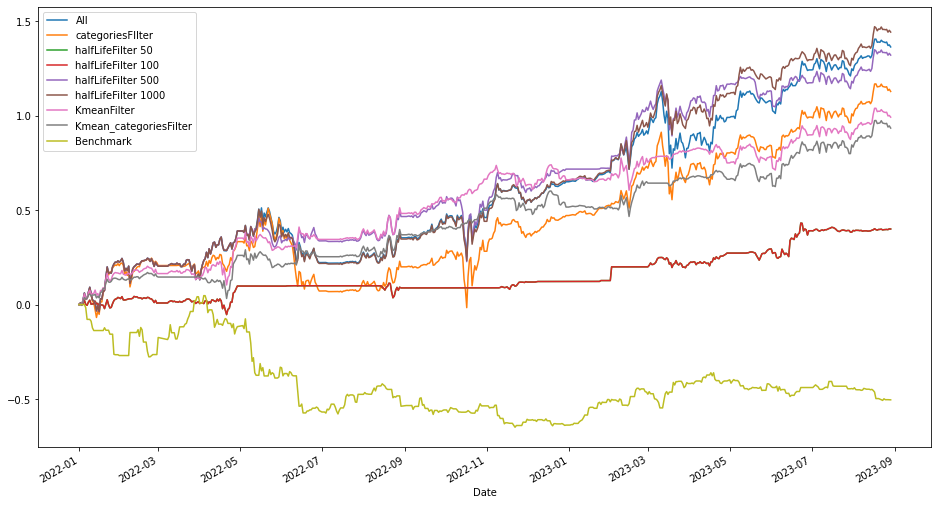

In [22]:
strategyDailyReturn = strategyDailyReturn.fillna(0)
strategyCumReturn = (1 + strategyDailyReturn).cumprod() - 1
strategyCumReturn.plot(figsize=(16, 9))

In [13]:
# pf.create_full_tear_sheet(
#     returns=dailyReturn,
#     benchmark_rets= benchmark_rets
# )